In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from ISLP import load_data

In [2]:
from scipy.stats import (ttest_1samp, ttest_rel, ttest_ind, t as t_dbn)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests as mult_test

# Resources

https://www.youtube.com/watch?v=K8LQSvtjcEo&t=302s<br>
https://www.youtube.com/watch?v=c9-zvw3AY3Q&list=PLoROMvodv4rPP6braWoRt5UCXYZ71GZIQ&index=108
https://www.youtube.com/watch?v=LVKLyt1B35w

# Introductory example

* The family-wise error rate tries to controls is the chance of making any mistakes
* the False Discovery Rate (FDR) controls the proportion of mistakes among the rejected

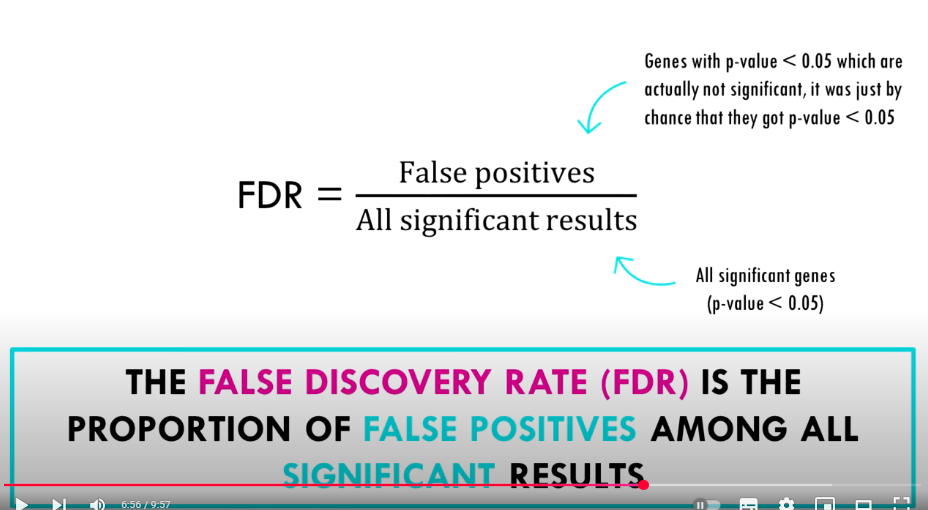


e.g. if we do ~ 100 hypothesis tests and we control the FDR at around 20 %, we conclude that around 20 of those 100 tests are likely to be truly null that we didn't actually make a discovery. But on the other hand, we make 80 / 100 true discoveries.

A hypothesis test for all 2.000 fund managers in the Fund dataset is performed.<br>

$H_{0,j}: \mu_{j} = 0$

One-sample t-test which states that the jth fund manager's mean return is zero.

In [4]:
Fund = load_data("Fund")
fund_pvalues = np.empty(2000)

for i, manager in enumerate(Fund.columns):

    fund_pvalues[i] = ttest_1samp(Fund[manager], 0).pvalue

Too many managers to consider trying to control the FWER. Instead, controling FDR is focused. That is, the expected fraction of rejected H0 that are actually false positives. <br>
The multipletests() function can be used to carry out the benjamini-hochberg procedure.<br>
The q-values are the adjusted p-values

In [5]:
fund_qvalues = mult_test(fund_pvalues, method = "fdr_bh")[1]
fund_qvalues

array([0.08988921, 0.991491  , 0.12211561, ..., 0.18369843, 0.85233743,
       0.96814414])

The q-values output by the BH-Method can be interpreted as the smallest FDR threshold at which we would reject a particular H0.<br>
For instance, a q-val of 0.1 indicates that we can reject the corresponding H0 at an FDR >= 10%, but we can't reject the H0 at an FDR below 10%.<br>

if we control the FDR at 10%, then for how many of the fund managers can we reject $H_{0,j}: \mu_{j} = 0$?

In [6]:
(fund_qvalues <= 0.1).sum()

146

We find that 146 of the 2.000 fund managers have a q-val below 0.1; therefore, we are able to conclude that 146 of the fund managers beat the market at an FDR of 10%. <br>
Only about 15 (10% of 146) of these fund managers are likely to be false discoveries.

By contrast, if we had instead used Bonferroni's method to control the FWER at level $\alpha=0.1$, then we would have failed to reject any H0:

In [7]:
(fund_pvalues <= 0.1 / 2000).sum()

0

Benjamini-Hochberg method identifies the largest p-val such that $p_{(j)} < q_{j}/m$, and rejects all hypotheses for which the p-val is less than or equal to $p_{(j)}$.<br>
Below BH-Method is implemented in order to illustrate how it works. <br>

1) Order the pvals
2) identify all p-vals that satisfy $p_{(j)}<q_{j}/m$ (sorted_set_)
3) selected_ is a boolean array indicating which pvals are less than or equal to the largest pval in sorted_[sorted_set_]. Therefore, selected_ indexes the pvals rejected by the BH Method.

In [9]:
sorted_ = np.sort(fund_pvalues)
m = fund_pvalues.shape[0]
q = 0.1

sorted_set_ = np.where(sorted_ < q * np.linspace(1, m, m) / m)[0]

if sorted_set_.shape[0] > 0:
    selected_ = fund_pvalues < sorted_[sorted_set_].max()
    sorted_set_ = np.arange(sorted_set_.max())

else:
    selected_ = []
    sorted_set_ = []

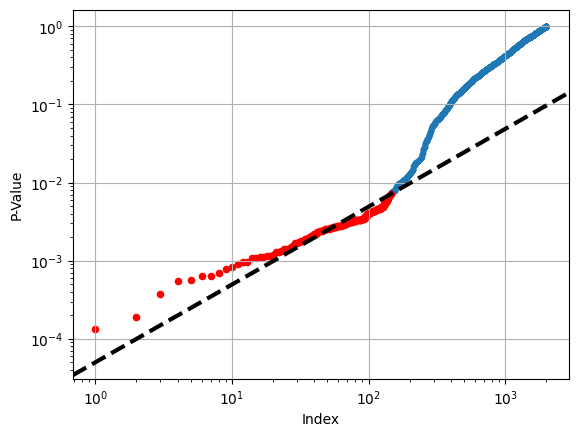

In [17]:
fig, ax = plt.subplots(1,1)

ax.scatter(np.arange(0, sorted_.shape[0]) + 1, sorted_, s = 10)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("P-Value")
ax.set_xlabel("Index")

ax.scatter(sorted_set_+1, sorted_[sorted_set_], c="r", s=20)
ax.axline((0,0), (1,q/m), c="k", ls="--", lw = 3)
ax.grid()


BH-Threshold

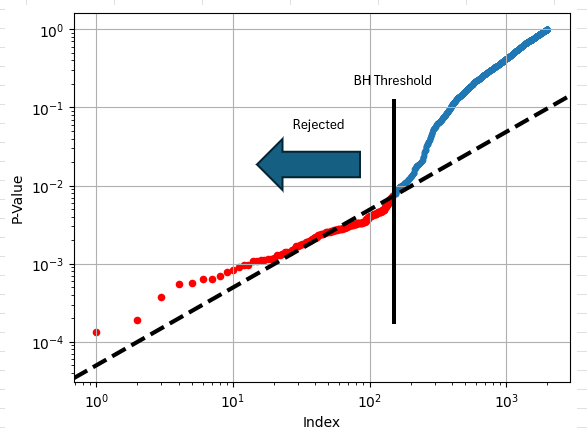